Leitura dos pacotes

In [1]:
%pip install lxml
%pip install unidecode
import os
import sys
import xml.etree.ElementTree as ET
import nltk
from nltk.tokenize import RegexpTokenizer
from unidecode import unidecode
import pandas as pd
import pickle
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import csv
import pandas as pd
import logging
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import re
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from nltk.stem import PorterStemmer
from sklearn.metrics import dcg_score
from sklearn.metrics import ndcg_score

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luanc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Data Prep

Retornar para pasta raiz, assumindo execução da pasta "./src". Se não for o caso alterar para os.chdir(pasta_raiz)

In [2]:
os.chdir('..')

In [3]:
if not os.path.exists("RESULT"):
    os.makedirs("RESULT")

In [4]:
logger = logging.getLogger(__name__)

f_handler = logging.FileHandler('./RESULT/logs.log', mode='w')
f_handler.setLevel(logging.DEBUG)
logger.setLevel(logging.DEBUG)

f_format = logging.Formatter("%(levelname)s: %(message)s")
f_handler.setFormatter(f_format)

logger.addHandler(f_handler)

In [5]:
def check_error():
    with open('RESULT/logs.log', 'r') as f:
        log_content = f.read()
    if 'ERROR' in log_content:
        logger.critical("Execution interrupted. Adjust informed erros")
        f.close()
        sys.exit(1)

In [6]:
config_files = {
    "gli": {"field": ["LEIA","ESCREVA"]},
    "busca": {"field": ["MODELO", "CONSULTAS", "RESULTADOS"]},
    "pc": {"field": ["LEIA", "CONSULTAS", "ESPERADOS"]}, #read only once
    "index": {"field": ["LEIA","ESCREVA"]}  #read only once
}

In [7]:
cfg_file = "gli.cfg"
logger.info("Reading config file " + cfg_file)
gli_stemmer = False
with open(os.path.join("config_files", cfg_file), "r") as f:
    lines = f.readlines()
    if lines[0].replace(" ","").replace("\n", "") == "STEMMER":
        gli_stemmer = True
    elif lines[0].replace(" ","").replace("\n", "") =="NOSTEMMER":
        gli_stemmer = False
    else:
    # if option is not 'STEMMER' or 'NOSTEMMER', log error
        logger.error(f"Error: stemmer selection is not valid in {cfg_file}")
        
    fields = [config_files[name]['field'] for name in config_files if cfg_file.endswith(name + '.cfg')][0]
    gli_read = []
    for line in lines[1:]:
    # check if line has format "field=file_path"
        field, file_path = line.strip().split('=')
        # if field is 'LEIA', add file_path to gli_read
        if field == 'LEIA':
            gli_read.append(file_path)
            # check if file_path exists
            if not os.path.exists(file_path):
                logger.error(f"Error: {file_path} doesn't exist")
        # if field is 'ESCREVA', check that it is the last field
        elif field == 'ESCREVA':
            if field not in fields[-1]:
                logger.error(f"Error: {field} field should be the last field in {cfg_file}")
            gli_write = file_path
        # if field is not 'LEIA' or 'ESCREVA', log error

        elif field not in fields:
            logger.error(f"Error: {field} is not a valid field in {cfg_file}")
    # check that all LEIA files exist
    for leia_file in gli_read:
        if not os.path.exists(leia_file):
            print(f"Error: {leia_file} doesn't exist")
    # check that all fields are present
    if set(fields) != set(['LEIA', 'ESCREVA']):
        print(f"Error: {cfg_file} should have only 'LEIA' and 'ESCREVA' fields")
    if gli_stemmer:
        gli_write = gli_write[:-4] + "-STEMMER" + ".csv"
    else:
        gli_write = gli_write[:-4] + "-NOSTEMMER" + ".csv"

In [8]:
cfg_file = "busca.cfg"
logger.info("Reading config file " + cfg_file)

busca_model = None
busca_queries = None
busca_results = None


with open(os.path.join("config_files", cfg_file), "r") as f:
    lines = f.readlines()
    fields = [config_files[name]['field'] for name in config_files if cfg_file.endswith(name + '.cfg')][0]


    for line in lines:
        # check if line has format "field=file_path"
        field, file_path = line.strip().split('=')
        # if field is 'LEIA', add file_path to gli_read
        if field == 'MODELO':
            if busca_model != None:
                logger.error(f"Repeated field in {cfg_file}")
            busca_model = file_path
            
        # if field is 'ESCREVA', check that it is the last field
        elif field == 'CONSULTAS':
            if busca_queries != None:
                logger.error(f"Repeated field in {cfg_file}")
            busca_queries = file_path

        elif field == 'RESULTADOS':
            if busca_results != None:
                logger.error(f"Repeated field in {cfg_file}")
            busca_results = file_path

        # if field is not correct, log error
        elif field not in fields:
            logger.error(f"Error: {field} is not a valid field in {cfg_file}")
    # check that all fields are present
    if set(fields) != set(['MODELO', 'CONSULTAS','RESULTADOS']):
        logger.error(f"Error in {cfg_file} adjust fields accordingly")
    if gli_stemmer:
        busca_results = busca_results[:-4] + "-STEMMER" + ".csv"
    else:
        busca_results = busca_results[:-4] + "-NOSTEMMER" + ".csv"

In [9]:
cfg_file = "index.cfg"
logger.info("Reading config file " + cfg_file)

index_read = None
index_write = None

with open(os.path.join("config_files", cfg_file), "r") as f:
    lines = f.readlines()
    fields = [config_files[name]['field'] for name in config_files if cfg_file.endswith(name + '.cfg')][0]
    for line in lines:    
    # check if line has format "field=file_path"
        field, file_path = line.strip().split('=')
        
        if field == 'LEIA':
            if index_read != None:
                logger.error(f"Repeated field in {cfg_file}")
            index_read = file_path
        
        elif field == 'ESCREVA':
            # if field is 'ESCREVA', check that it is the last field
            if field not in fields[-1]:
                logger.error(f"Error: {field} field should be the last field in {cfg_file}")
            if index_write != None:
                logger.error(f"Repeated field in {cfg_file}")
            index_write = file_path
        # if field is not 'LEIA' or 'ESCREVA', print error
        elif field not in fields:
            logger.error(f"Error: {field} is not a valid field in {cfg_file}")
    # check that all LEIA files exist
    for leia_file in gli_read:
        if not os.path.exists(leia_file):
            logger.error(f"Error: {leia_file} doesn't exist")
    # check that all fields are present
    if set(fields) != set(['LEIA', 'ESCREVA']):
        logger.error(f"Error: {cfg_file} should have only 'LEIA' and 'ESCREVA' fields")
    if gli_stemmer:
        index_read = index_read[:-4] + "-STEMMER" + ".csv"
    else:
        index_read = index_read[:-4] + "-NOSTEMMER" + ".csv"

In [10]:
cfg_file = "pc.cfg"
logger.info("Reading config file " + cfg_file)

pc_read = None
pc_queries = None
pc_expected = None
pc_stemmer = False

with open(os.path.join("config_files", cfg_file), "r") as f:
    lines = f.readlines()

    if lines[0].replace(" ","").replace("\n", "") == "STEMMER":
        pc_stemmer = True
    elif lines[0].replace(" ","").replace("\n", "") == "NOSTEMMER":
        pc_stemmer = False
    else:
    # if option is not 'STEMMER' or 'NOSTEMMER', log error
        logger.error(f"Error: stemmer selection is not valid in {cfg_file}")

    fields = [config_files[name]['field'] for name in config_files if cfg_file.endswith(name + '.cfg')][0]
    for line in lines[1:]:
        # check if line has format "field=file_path"
        field, file_path = line.strip().split('=')
        # if field is 'LEIA', add file_path to gli_read
        if field == 'LEIA':
            if pc_read != None:
                logger.error(f"Repeated field in {cfg_file}")
            pc_read = file_path
            
        # if field is 'ESCREVA', check that it is the last field
        elif field == 'CONSULTAS':
            if pc_queries != None:
                logger.error(f"Repeated field in {cfg_file}")
            pc_queries = file_path

        elif field == 'ESPERADOS':
            if pc_expected != None:
                logger.error(f"Repeated field in {cfg_file}")
            pc_expected = file_path

        # if field is not correct, print error
        elif field not in fields:
            logger.error(f"Error: {field} is not a valid field in {cfg_file}")
    # check that all fields are present
    if set(fields) != set(['LEIA', 'CONSULTAS','ESPERADOS']):
        logger.error(f"Error: {cfg_file} adjust fields accordingly")


In [11]:
check_error()

In [12]:
print(f"Generate inverse list read file(s): {gli_read}")
print(f"Generate inverse list write file: {gli_write}")
print(f"Searcher model: {busca_model}")
print(f"Searcher queries: {busca_queries}")
print(f"Searcher results: {busca_results}")
print(f"Query processor read file: {pc_read}")
print(f"Query processor query file: {pc_queries}")
print(f"Query processor expected file: {pc_expected}")
print(f"Index read file: {index_read}")
print(f"Index write file: {index_write}")

Generate inverse list read file(s): ['CysticFibrosis2-20230331/data/cf74.xml', 'CysticFibrosis2-20230331/data/cf75.xml', 'CysticFibrosis2-20230331/data/cf76.xml', 'CysticFibrosis2-20230331/data/cf77.xml', 'CysticFibrosis2-20230331/data/cf78.xml', 'CysticFibrosis2-20230331/data/cf79.xml']
Generate inverse list write file: RESULT/LISTA INVERSA-STEMMER.csv
Searcher model: RESULT/ModeloTFIDF.pkl
Searcher queries: RESULT/CONSULTAS.csv
Searcher results: RESULT/RESULTADOS-STEMMER.csv
Query processor read file: CysticFibrosis2-20230331/data/cfquery.xml
Query processor query file: RESULT/CONSULTAS.csv
Query processor expected file: RESULT/ESPERADOS.csv
Index read file: RESULT/LISTA INVERSA-STEMMER.csv
Index write file: RESULT/ModeloTFIDF.pkl


In [13]:
paths = gli_read + [gli_write] + [busca_model] + [busca_queries] + [busca_results] + [pc_read] + [pc_queries] + [pc_expected] + [index_read] + [index_write]
for file_path in paths:
    dir_path = os.path.dirname(file_path)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

Module 1 - Query Processor

In [14]:
logger.info("Module 1: Query processor started")
def process_query_text(query):

    text = query.upper()
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+') 
    words_list = tokenizer.tokenize(unidecode(text))

    if pc_stemmer:
        words_list = [PorterStemmer().stem(word) for word in words_list]

    words = [word for word in words_list]
    processed_query = " ".join(words)
    return processed_query

In [15]:
def read_queries():
    query_file = pc_read
    logger.info("Reading file " + query_file)

    
    tree = ET.parse(query_file)
    root = tree.getroot()

    queries = {}

    for query in root.iter("QUERY"):
        query_number = int(query.find("QueryNumber").text)
        query_text = re.sub('\s+', ' ',query.find("QueryText").text.strip().replace(";", " "))
        num_results = int(query.find("Results").text)

        query_text = process_query_text(query_text)

        queries[query_number] = {
            "query_text": query_text,
            "num_results": num_results
        }

        expected_results = {}

        for item in query.iter("Item"):
            expected_result = int(item.text)
            expected_score = 0

            for value in item.get("score"):
                expected_score += int(value)

            expected_results[expected_result] = expected_score
            expected_results
        queries[query_number]["expected_results"] = expected_results
    return queries

In [16]:
def write_queries(queries):
    query_data_list = []
    
    for query_number, query_data in queries.items():
        expected_results = query_data["expected_results"]

        expected_results_str = ";".join([f"{doc_num}:{doc_votes}" for doc_num, doc_votes in expected_results.items()])
        query_data_list.append({"QueryNumber": query_number, "QueryText": query_data["query_text"], "NumResults": query_data["num_results"], "ExpectedResults": expected_results_str})

    queries_df = pd.DataFrame(query_data_list, columns=["QueryNumber", "QueryText"])

    processed_queries_file = pc_queries
    queries_df.to_csv(processed_queries_file, index=False, sep=";")
    logger.info("%d queries read and written to %s." % (queries_df.shape[0], processed_queries_file))


In [17]:
def write_expected(queries):
    logger.info("Writing expected results.")
    if len(queries.keys()) == 0:
        logger.error("Method 'read_and_write_queries' must be executed first.")
        return

    expected_results_list = []

    for query_number in sorted(queries.keys()):
        expected_results = queries[query_number]["expected_results"]
        for document_number in sorted(expected_results, key = expected_results.get, reverse = True):
            expected_results_list.append({"QueryNumber": query_number, "DocNumber": document_number, "DocVotes": str(expected_results[document_number])})
    
    expected_results_df = pd.DataFrame(expected_results_list, columns=["QueryNumber", "DocNumber","DocVotes"])

    expected_results_file = pc_expected
    expected_results_df.to_csv(expected_results_file, index=False, sep=";")
    logger.info("%d expected results written to '%s'." % (expected_results_df.shape[0], expected_results_file))

In [18]:
def pc_module_run():
    queries = read_queries()
    write_queries(queries)
    write_expected(queries)


Run Module 1

In [19]:
pc_module_run()
logger.info("Module 1: Query processor finished")

Module 2 - Invert List Generator

In [20]:
logger.info("Module 2: Inverted List Generator started")

def read_input_files():
    input_documents = {}

    for path in gli_read:
        logger.info("Reading file " + path)

        tree = ET.parse(path)
        root = tree.getroot()

        for document in root.iter("RECORD"):
            doc_identifier = document.find("RECORDNUM")
            doc_text = document.find("ABSTRACT")

            if doc_identifier is not None:
                doc_identifier = int(doc_identifier.text.strip())
            else:
                logger.warning("RECORDNUM not found for a doc in  %s" %path)
                continue
            if doc_text is None:
                doc_text = document.find("EXTRACT")

                if doc_text is None:
                    logger.warning("Document %d in %s without ABSTRACT and EXTRACT." %(doc_identifier, path))
                    continue

            doc_text = doc_text.text.strip()

            # logs reading document

            input_documents[doc_identifier] = doc_text

    return input_documents

In [21]:
def generate_inverted_list(input_documents):
    inverted_list = {}
        
    for document_id in sorted(input_documents.keys()):
        text = input_documents[document_id].upper()
        tokenizer = RegexpTokenizer(r'[a-zA-Z]+') 
        words_list = tokenizer.tokenize(unidecode(text))

        if gli_stemmer:
            words_list = [PorterStemmer().stem(word) for word in words_list]

        for word in words_list:
            if word not in inverted_list:
                inverted_list[word] = []

            inverted_list[word].append(document_id)

    logger.info("Inverted list generated with %d terms considered." %len(inverted_list))

    return inverted_list

In [22]:
def save_inverted_list(gli_write, inverted_list):

    inverted_df = pd.DataFrame({"term": sorted(inverted_list.keys()), "indexes": [sorted(inverted_list[term]) for term in sorted(inverted_list.keys())]})
    inverted_df["indexes"] = inverted_df["indexes"].apply(lambda x: "[" + ",".join(str(num) for num in x) + "]")
    inverted_df.to_csv(gli_write, sep=";", index=False,header = False)

    total_terms = inverted_df.shape[0]
    logger.info("%d terms written. Saved inverted list to '%s'" % (total_terms, gli_write))

In [23]:
def gli_module_run():
    input_documents = read_input_files()
    inverted_list = generate_inverted_list(input_documents)
    save_inverted_list(gli_write, inverted_list)

Run Module 2

In [24]:
gli_module_run()
logger.info("Module 2: Generate Inverted List finished")

Module 3 - Indexer

In [25]:
logger.info("Module 3: Index started")

def read_docs_dict(index_read, min_length_word=2):
    docs_dict = {}

    with open(index_read, 'r') as f:
        reader = csv.reader(f, delimiter=';')
        for row in reader:
            word = row[0]
            if len(word) >= min_length_word:
                docs = [int(doc) for doc in row[1][1:-1].split(',')]
                docs_dict[word] = docs
    logger.info("Loading word and documents data from %s" %index_read)

    return docs_dict

In [26]:
def get_tfidf_model(docs_dict):
    docs = []
    for doc_index in set([doc for docs in docs_dict.values() for doc in docs]):
        doc = ' '.join([word for word, docs in docs_dict.items() if doc_index in docs])
        docs.append(doc)

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(docs)

    logger.info("tfidf matrix created.")
    return tfidf_matrix, vectorizer
    
#dense_matrix = tfidf_matrix.toarray()

In [27]:
docs_dict = {}

with open(index_read, 'r') as f:
    reader = csv.reader(f, delimiter=';')
    for row in reader:
        word = row[0]
        if len(word) >= 2:
            docs = [int(doc) for doc in row[1][1:-1].split(',')]
            docs_dict[word] = docs
logger.info("Loading word and documents data from %s" %index_read)

docs = []
for doc_index in set([doc for docs in docs_dict.values() for doc in docs]):
    doc = ' '.join([word for word, docs in docs_dict.items() if doc_index in docs])
    docs.append(doc)

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(docs)
tfidf_matrix

<1215x6494 sparse matrix of type '<class 'numpy.float64'>'
	with 90509 stored elements in Compressed Sparse Row format>

In [28]:
def save_model(tfidf_matrix, vectorizer, index_write):
    with open(index_write, 'wb') as f:
        pickle.dump((tfidf_matrix, vectorizer), f)
    logger.info("tfidf matrix and vectorizer saved to %s."%index_write)

In [29]:
def index_module_run():
    docs_dict = read_docs_dict(index_read)
    tfidf_matrix, vectorizer = get_tfidf_model(docs_dict)
    save_model(tfidf_matrix, vectorizer, index_write)

Run Module 3

In [30]:
index_module_run()
logger.info("Module 3: Index finished.")

Module 4 - Searcher

In [31]:
logger.info("Module 4: Searcher started")
def load_tfidf_matrix():
    # Load the tf-idf matrix from a pickle file
    with open(busca_model, 'rb') as f:
        tfidf_matrix, vectorizer = pickle.load(f)
        logger.info("tfidf model loaded from %s" %busca_model)
        return tfidf_matrix, vectorizer

In [32]:
def load_queries(busca_queries, stemmer = False):
    queries_df = pd.read_csv(busca_queries, delimiter=';', quotechar='"')
    queries = dict(zip(queries_df['QueryNumber'], queries_df['QueryText']))
    logger.info("Queries loaded from %s" %busca_queries)
    return queries


In [33]:
def calculate_similarity(tfidf_matrix, vectorizer, queries):
    query_matrix = vectorizer.transform(queries.values())
    query_matrix = TfidfVectorizer(vocabulary=vectorizer.vocabulary_).fit_transform(queries.values()) 
    #.sign() is used so weight is 1 for all words in query and 0 if word not in query
    query_matrix_binary = query_matrix.sign() 

    similarity_matrix = cosine_similarity(tfidf_matrix, query_matrix_binary)
    results = []

    for query_number, query_text in queries.items():
        similarity_scores = similarity_matrix[:, list(queries.keys()).index(query_number)]
        sorted_indices = np.argsort(similarity_scores)[::-1]

        for rank, index in enumerate(sorted_indices):
            document_number = index + 1
            similarity_distance = similarity_scores[index]
            results.append([query_number, [rank+1, document_number, similarity_distance]])

    return results

In [34]:
def write_results(busca_results, results):
    with open(busca_results, 'w', newline='') as f:
        writer = csv.writer(f, delimiter=';')
        writer.writerows(results)
    logger.info("Results saved to %s" %busca_results)

In [35]:
def busca_module_run():
    tfidf_matrix, vectorizer = load_tfidf_matrix() 
    queries = load_queries(busca_queries)
    results = calculate_similarity(tfidf_matrix, vectorizer, queries)
    write_results(busca_results, results)

Visualizing the query matrix.

In [36]:
tfidf_matrix, vectorizer = load_tfidf_matrix() 

queries = load_queries(busca_queries)
query_matrix = vectorizer.transform(queries.values())
query_matrix = TfidfVectorizer(vocabulary=vectorizer.vocabulary_).fit_transform(queries.values()) 
#.sign() is used so weight is 1 for all words in query and 0 if word not in query
query_matrix = query_matrix.sign() 

# Get words (feature names) from vectorizer
feature_names = vectorizer.get_feature_names_out()

# Loop through queries
for query_index, (query_key, query_text) in enumerate(queries.items()):
    # Get the feature indices and corresponding weight
    feature_indices = query_matrix[query_index].indices
    weights_vector = query_matrix[query_index, feature_indices].toarray()[0]

    # Map indices and words
    words = [feature_names[idx] for idx in feature_indices]

    # Print words and weight
    for word, weight in zip(words, weights_vector):
        print(f"Query {query_key}: {query_text}\tWord: {word}\tWeight: {weight}")

Query 1: what are the effect of calcium on the physic properti of mucu from cf patient	Word: are	Weight: 1.0
Query 1: what are the effect of calcium on the physic properti of mucu from cf patient	Word: calcium	Weight: 1.0
Query 1: what are the effect of calcium on the physic properti of mucu from cf patient	Word: cf	Weight: 1.0
Query 1: what are the effect of calcium on the physic properti of mucu from cf patient	Word: effect	Weight: 1.0
Query 1: what are the effect of calcium on the physic properti of mucu from cf patient	Word: from	Weight: 1.0
Query 1: what are the effect of calcium on the physic properti of mucu from cf patient	Word: mucu	Weight: 1.0
Query 1: what are the effect of calcium on the physic properti of mucu from cf patient	Word: of	Weight: 1.0
Query 1: what are the effect of calcium on the physic properti of mucu from cf patient	Word: on	Weight: 1.0
Query 1: what are the effect of calcium on the physic properti of mucu from cf patient	Word: patient	Weight: 1.0
Query 1: 

Run Module 4

In [37]:
busca_module_run()
logger.info("Module 4: Searcher finished")
logger.info("Execution completed")

Module 5: Evaluation

In [38]:
expected_df = pd.read_csv(pc_expected, sep=';')
results_df = pd.read_csv(busca_results, sep=';', header = None, names = ['QueryNumber', 'Column2'])

In [39]:
# Split Rank, DocNumber and Cosine_distance_metric into 3 columns.
new_columns = results_df['Column2'].str.strip("[]").str.split(",", expand=True)
new_columns.columns = ['Rank', 'DocNumber', 'cosine_distance_metric']
results_df = results_df.drop(columns=['Column2']).join(new_columns)

# Change column dtype. After split they are read as 'object'.
results_df['Rank'] = results_df['Rank'].astype('int64')
results_df['DocNumber'] = results_df['DocNumber'].astype('int64')
results_df['cosine_distance_metric'] = results_df['cosine_distance_metric'].astype('float')

In [40]:
# join results and expected dataframes
merged_df = results_df.merge(expected_df, on=['QueryNumber', 'DocNumber'], how='left')

# Sort by querynumber and rank
sorted_df = merged_df.sort_values(by=['QueryNumber','Rank'])

# Create a relevance binary classification. If docvotes > 1 the document is relevant for that query (labels = 1).
sorted_df['labels'] = np.where(sorted_df['DocVotes'] > 0, 1, 0)
sorted_df


,QueryNumber,Rank,DocNumber,cosine_distance_metric,DocVotes,labels
0,1,1,431,0.189792,NaN,0
1,1,2,559,0.189303,NaN,0
2,1,3,51,0.182264,NaN,0
3,1,4,842,0.175430,NaN,0
4,1,5,1139,0.168006,NaN,0
...,...,...,...,...,...,...
120280,100,1211,298,0.025681,NaN,0
120281,100,1212,931,0.025644,NaN,0
120282,100,1213,356,0.023032,NaN,0
120283,100,1214,1001,0.021029,NaN,0


Preparing directories and filenames

In [41]:
if not os.path.exists("AVALIA"):
    os.makedirs("AVALIA")
evaluation_dir = "AVALIA"
    
if gli_stemmer:
    report_file = "RELATORIO-STEMMER.md"
    r_precision_histogram_filename = "R_Precision_histogram-stemmer"
    eleven_point_plot_curve_filename = "11_points_curve-stemmer"
else:
    report_file = "RELATORIO-NOSTEMMER.md"
    r_precision_histogram_filename = "R_Precision_histogram-nostemmer"
    eleven_point_plot_curve_filename = "11_points_curve-nostemmer"

11-points precision recall curve

In [42]:
def eleven_points_precision_recall_curve(filepath,filename): 
    # Initialize empty list to store precision and recall for each query
    precision_values = []
    recall_values = []

    # Loop through each query
    for query_number in sorted_df['QueryNumber'].unique():
        # Filter by query
        query_df = sorted_df[sorted_df['QueryNumber'] == query_number]
        
        # Get the relevant documents
        relevant_documents = query_df[query_df['labels'] == 1]
        # Get total relevant documents for current query
        total_relevant_documents = len(relevant_documents)
        
        # Calculate precision and recall at fixed intervals
        precision = []
        recall = []
        
        number_of_points = 11
        incremental_results_index = int(len(query_df) / number_of_points)
        
        for i in range(number_of_points):
            results_ranking = query_df.iloc[:((i + 1) * incremental_results_index)]
            true_positives = len(results_ranking[results_ranking['labels'] == 1])
            
            precision.append(true_positives / len(results_ranking))
            recall.append(true_positives / total_relevant_documents)
        
        # Append precision and recall
        precision_values.append(precision)
        recall_values.append(recall)

    # Calculate mean values across all queries
    mean_precisions = np.mean(precision_values, axis=0)
    mean_recalls = np.mean(recall_values, axis=0)

    # Plot mean precision x meal recall scatter plot
    plt.scatter(mean_recalls, mean_precisions)
    plt.title("Mean Precision x Mean Recall")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.savefig(os.path.join(filepath, filename) +".png")
    plt.savefig(os.path.join(filepath, filename) + "-2.pdf", format='pdf')
    
    # Save csv file with mean precision and mean recall for all 11 points.
    df = pd.DataFrame({"Precision": mean_precisions, "Recall": mean_recalls})
    df.to_csv(f"{os.path.join(filepath, filename)}-1.csv")
    
    plt.show()

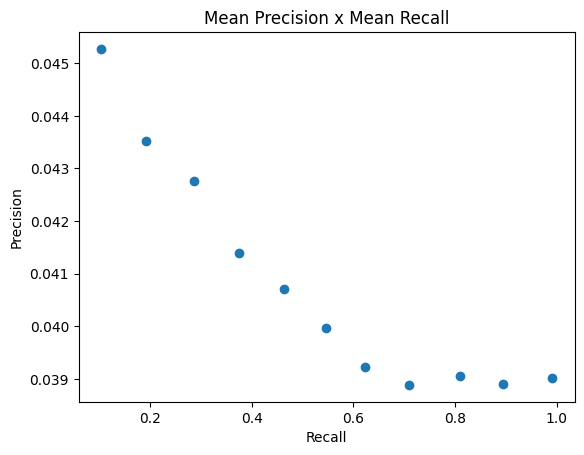

In [43]:
eleven_points_precision_recall_curve(evaluation_dir,eleven_point_plot_curve_filename)

logger.info(f"{eleven_point_plot_curve_filename} csv and pdf files created") # update log

F1 score

In [44]:
def f1():

    # Initialize true positives, false positives, and false negatives for each query
    true_positives = []
    false_positives = []
    false_negatives = []

    # Loop through all queries
    for query_number in sorted_df['QueryNumber'].unique():
        # Filter query
        query_df = sorted_df[sorted_df['QueryNumber'] == query_number]
        
        # Get relevant documents
        relevant_documents = query_df[query_df['labels'] == 1]
        
        # Get number of tp, fp, and false negative
        tp = len(relevant_documents)
        fp = np.sum(query_df['labels'] == 0)
        fn = 0 if tp > 0 else 1
        true_positives.append(tp)
        false_positives.append(fp)
        false_negatives.append(fn)

    # Calculate quantities for each query
    precisions = np.divide(true_positives, np.add(true_positives, false_positives))
    recalls = np.divide(true_positives, np.add(true_positives, false_negatives))
    f1_scores = np.divide(2 * np.multiply(precisions, recalls), np.add(precisions, recalls))

    # Calculate average f1 score across all queries
    avg_f1 = np.mean(f1_scores)

    return avg_f1


In [45]:
print(f1())

0.0724696466960625


Precision@5 and Precision@10

In [46]:
def precision_at_k(k):

    # Initialize precision_at_k
    precision_at_k = []

    # Loop through all queries
    for query_number in sorted_df['QueryNumber'].unique():
        # Filter query
        query_df = sorted_df[sorted_df['QueryNumber'] == query_number]
        
        # Get label and rank
        labels = query_df['labels']
        ranks = query_df['Rank']
        
        # Calculate precision@k, selecting only combinations of query and doc for which doc rank <= k.
        precisionk = np.mean(labels[ranks <= k])
        
        # Update precision_at_k
        precision_at_k.append(precisionk)

    # Calculate average precision@k across all queries
    avg_precision_at_k = np.mean(precision_at_k)

    return avg_precision_at_k

Precision@5

In [47]:
print(precision_at_k(5))

0.08080808080808081


Precision@10

In [48]:
print(precision_at_k(10))

0.0707070707070707


R-Precision Histogram

In [49]:
def r_precision_histogram(filepath, filename):

    # Initialize query numbers and r_precision_values
    query_numbers = []
    r_precision_values = []

    # Loop all queries
    for query_number in sorted_df['QueryNumber'].unique():
        # Filter query
        query_df = sorted_df[sorted_df['QueryNumber'] == query_number]
        
        # Calculate R precision
        labels = query_df['labels']
        r_precision = np.mean(labels)
        
        # Update query_numbers and r_precision
        query_numbers.append(query_number)
        r_precision_values.append(r_precision)

    # Plot histogram
    plt.bar(query_numbers, r_precision_values, color='b')
    plt.xlabel('Query Number')
    plt.ylabel('R Precision')
    plt.title('R Precision for Each Query')
    plt.grid(True)

    # Save plot as png (to be added to md file) and pdf 
    plt.savefig(os.path.join(filepath, filename) + ".png")
    plt.savefig(os.path.join(filepath, filename) + "-2.pdf", format='pdf')
    
    #Save csv dataframe with r_precision data for all queries
    df = pd.DataFrame({"QueryNumber": query_numbers, "R_Precision": r_precision_values})
    df.to_csv(f"{os.path.join(filepath, filename)}-1.csv")
    
    plt.show()

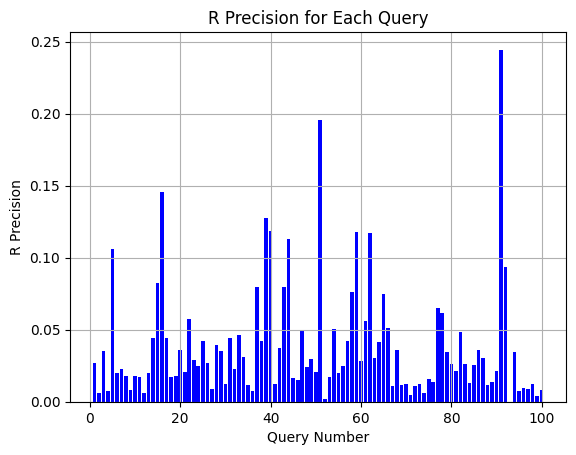

In [50]:
r_precision_histogram(evaluation_dir, r_precision_histogram_filename)
logger.info(f"{r_precision_histogram_filename} csv and pdf files created")

Mean Average Precision

In [51]:
def mean_average_precision():

    # Initialize average_precision_values
    average_precision_values = []

    # Loop through queries
    for query_number in sorted_df['QueryNumber'].unique():
        # Filter query
        query_df = sorted_df[sorted_df['QueryNumber'] == query_number]
        
        # Get labels
        labels = query_df['labels']
        
        # Calculate precision
        precision = np.cumsum(labels) / (np.arange(len(labels)) + 1)
        
        # Calculate average precision
        average_precision = np.sum(precision * labels) / np.sum(labels)
        
        # Update average_precision_values
        average_precision_values.append(average_precision)

    # Calculate mean across all queries
    mean_average_precision = np.mean(average_precision_values)

    return mean_average_precision

In [52]:
print(mean_average_precision())

0.04967016979703793


Mean Reciprocal Rank

In [53]:
def mean_reciprocal_rank():

    # Initialize reciprocal rank values
    reciprocal_rank_values = []

    # Loop through queries
    for query_number in sorted_df['QueryNumber'].unique():
        # Filter query
        query_df = sorted_df[sorted_df['QueryNumber'] == query_number]
        
        # Consider ranks up to 10
        ranks = query_df['Rank']
        ranks_limit = ranks[ranks <= 10]
        
        # Find first relevant document (label = 1)
        first_relevant_index = np.argmax(query_df['labels'].iloc[:10] == 1) if len(query_df) >= 10 else -1
        
        # Calculate reciprocal rank
        reciprocal_rank = 1 / (first_relevant_index + 1) if first_relevant_index >= 0 else 0
        
        # Update reciprocal_rank_values
        reciprocal_rank_values.append(reciprocal_rank)

    # Calculate mean reciprocal for all queries
    mean_reciprocal_rank = np.mean(reciprocal_rank_values)

    return mean_reciprocal_rank

In [54]:
print(mean_reciprocal_rank())

0.7312249478916145


Discounted Cumulative Gain

In [55]:
def discounted_cumulative_gain():

    #Initialize dcg_values
    dcg_values = []
    # Replace DocVotes missing data with 0.
    sorted_df['DocVotes'].fillna(0, inplace=True)

    # Loop through queries
    for query_number in sorted_df['QueryNumber'].unique():
        # Filter query
        query_df = sorted_df[sorted_df['QueryNumber'] == query_number]

        # Get the relevance scores and result scores
        relevance_scores = np.asarray([query_df['DocVotes']])
        result_scores = np.asarray([query_df['cosine_distance_metric']])

        # Calculate DCG for query. Up to Rank 10.
        dcg = dcg_score(relevance_scores, result_scores, k=10)
        
        # Update dcg_values
        dcg_values.append(dcg)

    # Calculate mean dcg for all queries
    mean_dcg = np.mean(dcg_values)

    return mean_dcg


In [56]:
print(discounted_cumulative_gain())

0.9886762276759508


Normalized Discounted Cumulative Gain

In [57]:
def normalized_discounted_cumulative_gain():

    #Initialize dcg_values
    ndcg_values = []
    # Replace DocVotes missing data with 0.
    sorted_df['DocVotes'].fillna(0, inplace=True)
    
    # Loop through queries
    for query_number in sorted_df['QueryNumber'].unique():
        # Filter query
        query_df = sorted_df[sorted_df['QueryNumber'] == query_number]

        # Get the relevance scores and result scores
        relevance_scores = np.asarray([query_df['DocVotes']])
        result_scores = np.asarray([query_df['cosine_distance_metric']])

        # Calculate DCG for query. Up to Rank 10.
        ndcg = ndcg_score(relevance_scores, result_scores, k=10)
        
        # Update ndcg_values
        ndcg_values.append(ndcg)

    # Calculate mean ndcg for all queries
    mean_ndcg = np.mean(ndcg_values)

    return mean_ndcg

In [58]:
print(normalized_discounted_cumulative_gain())

0.032881880410921605


In [59]:
total_queries = len(sorted_df['QueryNumber'].unique())
report_filepath = os.path.join(evaluation_dir, report_file)
f1_score = f1()
logger.info(f"F1 score calculated: {f1_score}.")
precision5 = precision_at_k(5)
logger.info(f"Precision@5 calculated: {precision5}.")
precision10 = precision_at_k(10)
logger.info(f"Precision@10 calculated: {precision10}.")
map = mean_average_precision()
logger.info(f"Mean average precision calculated: {map}.")
mrr = mean_reciprocal_rank()
logger.info(f"Mean reciprocal rank calculated: {mrr}.")
dcg = discounted_cumulative_gain()
logger.info(f"Discounted cumulativa gain calculated: {f1_score}.")
ndcg = normalized_discounted_cumulative_gain()
logger.info(f"Normalized discounted cumulative gain calculated: {f1_score}.")


In [60]:
def generate_evaluation_report():
    
    logger.info(f"Generating report file {report_file}.")
            
    with open(os.path.join(evaluation_dir, report_file), "w", encoding="utf-8") as file:
        file.write("# Avaliação dos Resultados\n\n")
        file.write(f"Total de queries: {total_queries}\n\n")
        file.write(f"Utilizando Porter Stemmer? {'Sim' if gli_stemmer else 'Não'}\n\n")
        file.write("## 11-point precision recall curve\n\n")
        file.write(f'![11 point precision recall curve]({eleven_point_plot_curve_filename}.png)\n\n')
        file.write("## F1 Score\n\n")
        file.write(f"F1 Score médio das queries: {f1_score}\n\n")
        file.write("## Precision@5\n\n")
        file.write(f"Precision@5 médio das questies: {precision5}\n\n")
        file.write("## Precision@10\n\n")
        file.write(f"Precision@10 médio das questies: {precision10}\n\n")
        file.write("## Histograma R-Precision\n\n")
        file.write(f'![R-Precision]({r_precision_histogram_filename}.png)\n\n')
        file.write("## Mean Average Precision\n\n")
        file.write(f"Mean Average Precision das queries: {map}\n\n")
        file.write("## Mean Reciprocal Rank\n\n")
        file.write(f"Mean Reciprocal Rank das queries: {mrr}\n\n") 
        file.write("## Discounted Cumulative Gain\n\n")
        file.write(f"Discounted Cumulative Gain médio das queries: {dcg}\n\n") 
        file.write("## Normalized Discounted Cumulative Gain\n\n")
        file.write(f"Normalized Discounted Cumulative Gain médio das queries: {ndcg}\n\n") 
  
        logger.info(f"Report file generated and saved at {report_filepath}.")

In [61]:
generate_evaluation_report()